## Group sequential boundaries: Pocock vs O’Brien–Fleming
This notebook compares two classic group sequential designs:

- O’Brien–Fleming (OBF): very strict early, close to fixed-horizon late
- Pocock: more permissive early, more conservative late

We show:

- Boundaries across looks (z-critical)
- One example stream: z-trajectory with both boundaries
- Monte Carlo comparison: stop times and rejection rates

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tecore.sequential.schema import (
    SequentialSpec,
    LookSchedule,
    SequentialConfig,
    SequentialMode,
    SpendingFunction,
    EffectDirection,
)
from tecore.sequential.preprocess import build_look_table_mean
from tecore.sequential.group_sequential import run_group_sequential
from tecore.sequential.simulate import SequentialSimConfig, simulate_ab_stream

plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams["axes.grid"] = True

## 1) Boundary shapes across looks
We compute per-look z-critical values under both spending functions, using the same schedule.

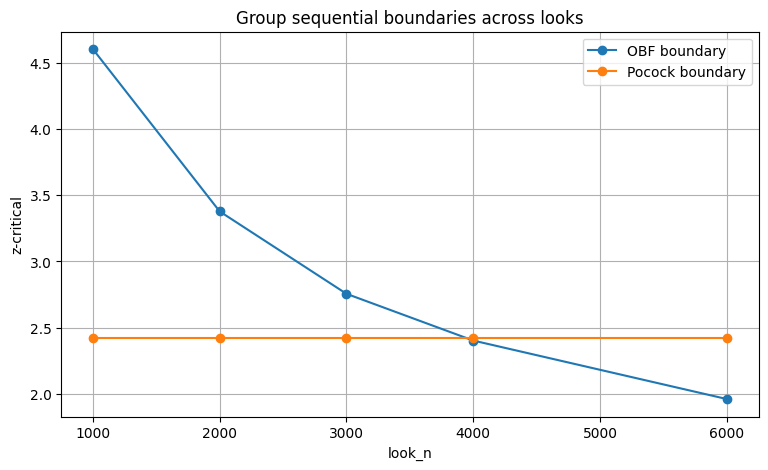

,look_n,z_obf,z_pocock
0,1000,4.603176,2.424821
1,2000,3.377194,2.424821
2,3000,2.754947,2.424821
3,4000,2.401868,2.424821
4,6000,1.959964,2.424821


In [7]:
N = 6000
looks = [1000, 2000, 3000, 4000, 6000, 8000, 10000]
alpha = 0.05

df0 = simulate_ab_stream(SequentialSimConfig(n=N, effect=0.0, noise_sd=1.0, heavy_tail=False, drift=False, seed=1, ratio=False))

spec = SequentialSpec(group_col="group", control_label="control", test_label="test", y_col="y", timestamp_col="timestamp")
schedule = LookSchedule(looks=looks)

cfg_obf = SequentialConfig(
    mode=SequentialMode.GROUP_SEQUENTIAL,
    alpha=alpha,
    two_sided=True,
    spending=SpendingFunction.OBRIEN_FLEMING,
    effect_direction=EffectDirection.TWO_SIDED,
    min_n_per_group=50,
)
cfg_poc = SequentialConfig(
    mode=SequentialMode.GROUP_SEQUENTIAL,
    alpha=alpha,
    two_sided=True,
    spending=SpendingFunction.POCOCK,
    effect_direction=EffectDirection.TWO_SIDED,
    min_n_per_group=50,
)

lt0, _ = build_look_table_mean(df0, spec, schedule, cfg_obf)
res_obf = run_group_sequential(lt0, cfg_obf)

lt1, _ = build_look_table_mean(df0, spec, schedule, cfg_poc)
res_poc = run_group_sequential(lt1, cfg_poc)

b_obf = res_obf.look_table["boundary_z"].to_numpy(dtype=float)
b_poc = res_poc.look_table["boundary_z"].to_numpy(dtype=float)
x = res_obf.look_table["look_n"].to_numpy(dtype=int)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, b_obf, marker="o", label="OBF boundary")
ax.plot(x, b_poc, marker="o", label="Pocock boundary")
ax.set_title("Group sequential boundaries across looks")
ax.set_xlabel("look_n")
ax.set_ylabel("z-critical")
ax.legend(loc="best")
plt.show()

display(pd.DataFrame({"look_n": x, "z_obf": b_obf, "z_pocock": b_poc}))

## 2) One stream: z-trajectory vs both boundaries
We simulate a modest effect and overlay z with both boundaries.

OBF: reject stopped= True stop_look= 3000
Pocock: reject stopped= True stop_look= 2000


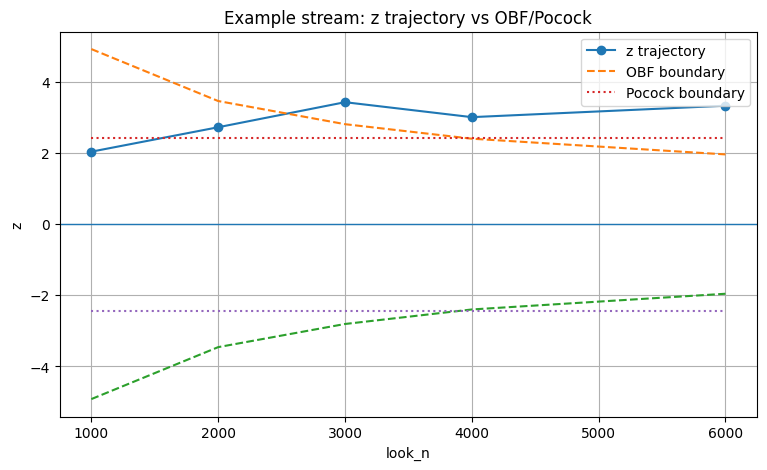

In [8]:
df = simulate_ab_stream(SequentialSimConfig(n=N, effect=0.08, noise_sd=1.0, heavy_tail=False, drift=False, seed=11, ratio=False))

lt, _ = build_look_table_mean(df, spec, schedule, cfg_obf)
res_obf = run_group_sequential(lt, cfg_obf)

lt, _ = build_look_table_mean(df, spec, schedule, cfg_poc)
res_poc = run_group_sequential(lt, cfg_poc)

x = res_obf.look_table["look_n"].to_numpy(dtype=int)
z = res_obf.look_table["z"].to_numpy(dtype=float)
b_obf = res_obf.look_table["boundary_z"].to_numpy(dtype=float)
b_poc = res_poc.look_table["boundary_z"].to_numpy(dtype=float)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, z, marker="o", label="z trajectory")
ax.plot(x, b_obf, linestyle="--", label="OBF boundary")
ax.plot(x, -b_obf, linestyle="--")
ax.plot(x, b_poc, linestyle=":", label="Pocock boundary")
ax.plot(x, -b_poc, linestyle=":")
ax.axhline(0.0, linewidth=1.0)
ax.set_title("Example stream: z trajectory vs OBF/Pocock")
ax.set_xlabel("look_n")
ax.set_ylabel("z")
ax.legend(loc="best")
plt.show()

print("OBF:", res_obf.decision, "stopped=", res_obf.stopped, "stop_look=", res_obf.stop_look)
print("Pocock:", res_poc.decision, "stopped=", res_poc.stopped, "stop_look=", res_poc.stop_look)

## 3) Monte Carlo: rejection rate and stop time distribution
We compare OBF and Pocock under a fixed effect.

Metrics:

- rejection rate (power proxy)
- average stop look (earliness)
- stop time distribution (histogram)

Rejection rate (OBF): 0.6583333333333333
Rejection rate (Pocock): 0.4583333333333333
Avg stop look (OBF): 5225.0
Avg stop look (Pocock): 4775.0


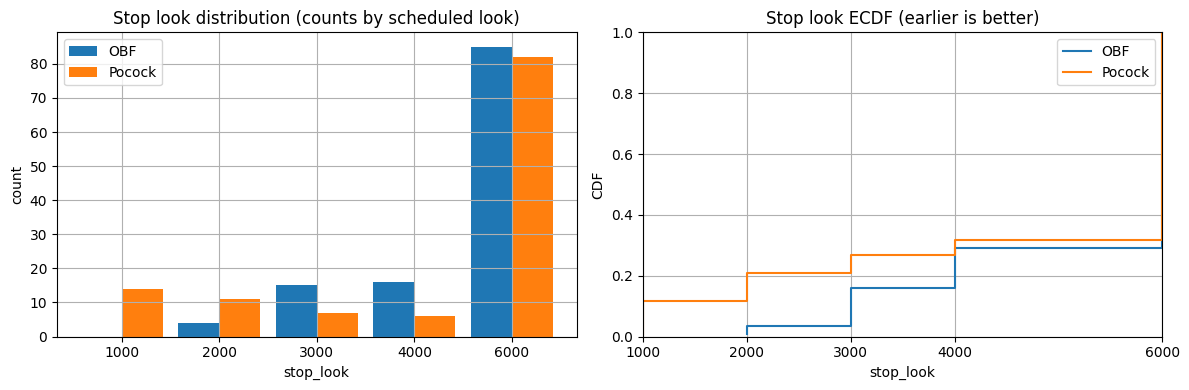

In [12]:
from scipy.stats import norm
n_sims = 120
N = 6000
looks = [1000, 2000, 3000, 4000, 6000] 
alpha = 0.05
effect = 0.06
seed0 = 2000

def z_two_sample(mean_c, var_c, n_c, mean_t, var_t, n_t, var_floor=1e-12):
    var_c = max(var_c, var_floor)
    var_t = max(var_t, var_floor)
    se = np.sqrt(var_c / n_c + var_t / n_t)
    return (mean_t - mean_c) / se

def boundary_obf(alpha, t, two_sided=True):
    a = alpha / 2 if two_sided else alpha
    z = norm.isf(a)
    return z / np.sqrt(max(t, 1e-12))

def boundary_pocock(alpha, K, two_sided=True):
    a = alpha / 2 if two_sided else alpha
    a_k = 1 - (1 - a) ** (1 / K)
    return norm.isf(a_k)

K = len(looks)
z_poc = boundary_pocock(alpha, K, two_sided=True)

obf_reject = []
poc_reject = []
obf_stop = []
poc_stop = []

rng = np.random.default_rng(seed0)

for s in range(n_sims):
    y_c = rng.normal(loc=0.0, scale=1.0, size=N//2)
    y_t = rng.normal(loc=effect, scale=1.0, size=N - N//2)

    stopped_obf = False
    stopped_poc = False
    stop_obf = looks[-1]
    stop_poc = looks[-1]

    for i, L in enumerate(looks, start=1):
        n_c = L // 2
        n_t = L - n_c

        c = y_c[:n_c]
        t = y_t[:n_t]

        z = z_two_sample(c.mean(), c.var(ddof=1), n_c, t.mean(), t.var(ddof=1), n_t)

        # boundaries
        t_info = L / looks[-1]
        z_obf = boundary_obf(alpha, t_info, two_sided=True)

        if (not stopped_obf) and (abs(z) >= z_obf):
            stopped_obf = True
            stop_obf = L

        if (not stopped_poc) and (abs(z) >= z_poc):
            stopped_poc = True
            stop_poc = L

    obf_reject.append(stopped_obf)
    poc_reject.append(stopped_poc)
    obf_stop.append(stop_obf)
    poc_stop.append(stop_poc)

obf_rej_rate = float(np.mean(obf_reject))
poc_rej_rate = float(np.mean(poc_reject))
obf_stop_avg = float(np.mean(obf_stop))
poc_stop_avg = float(np.mean(poc_stop))

print("Rejection rate (OBF):", obf_rej_rate)
print("Rejection rate (Pocock):", poc_rej_rate)
print("Avg stop look (OBF):", obf_stop_avg)
print("Avg stop look (Pocock):", poc_stop_avg)

obf_stop_arr = np.asarray(obf_stop, dtype=int)
poc_stop_arr = np.asarray(poc_stop, dtype=int)
looks_arr = np.asarray(looks, dtype=int)

obf_counts = np.array([(obf_stop_arr == L).sum() for L in looks_arr], dtype=int)
poc_counts = np.array([(poc_stop_arr == L).sum() for L in looks_arr], dtype=int)

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(1, 2, 1)
x = np.arange(len(looks_arr))
w = 0.42

ax1.bar(x - w/2, obf_counts, width=w, label="OBF")
ax1.bar(x + w/2, poc_counts, width=w, label="Pocock")

ax1.set_title("Stop look distribution (counts by scheduled look)")
ax1.set_xlabel("stop_look")
ax1.set_ylabel("count")
ax1.set_xticks(x)
ax1.set_xticklabels([str(L) for L in looks_arr], rotation=0)
ax1.legend(loc="best")

def ecdf(vals):
    vals = np.sort(vals)
    y = np.arange(1, len(vals) + 1) / len(vals)
    return vals, y

ax2 = fig.add_subplot(1, 2, 2)
x_obf, y_obf = ecdf(obf_stop_arr)
x_poc, y_poc = ecdf(poc_stop_arr)

ax2.step(x_obf, y_obf, where="post", label="OBF")
ax2.step(x_poc, y_poc, where="post", label="Pocock")

ax2.set_title("Stop look ECDF (earlier is better)")
ax2.set_xlabel("stop_look")
ax2.set_ylabel("CDF")
ax2.set_xticks(looks_arr)
ax2.set_xlim(looks_arr.min(), looks_arr.max())
ax2.set_ylim(0, 1)
ax2.legend(loc="best")

plt.tight_layout()
plt.show()

## Interpretation
- OBF typically requires stronger early evidence, so it is less likely to stop very early on weak signals; it behaves close to a fixed-horizon test near the final look.
- Pocock tends to be more permissive early, which may yield earlier stopping when effects are real, but it pays by being more conservative at later looks.

Practical guidance:

- Prefer OBF when you want early stopping to be rare unless evidence is very strong.
- Prefer Pocock when you value earlier decisions and accept a more conservative final threshold.

## Result summary

We compared two classic group sequential designs on the same pre-defined look schedule:

- Schedule (K = 5): `[1000, 2000, 3000, 4000, 6000]`
- Two-sided α = 0.05
- Simulated effect size: `effect = 0.06` (normal outcomes, i.i.d. stream)

Empirical results over **n_sims = 120** Monte Carlo runs:

- **Rejection rate (power proxy)**:
  - O’Brien–Fleming (OBF): **0.658**
  - Pocock: **0.458**

- **Average stop look** (lower = earlier decision; non-rejections stop at max look 6000):
  - OBF: **5225**
  - Pocock: **4775**

Interpretation:

- **Pocock stops earlier on average** (4775 vs 5225), consistent with its “more permissive early” boundary shape.
- In this particular simulation setup, **OBF rejects more often** (0.658 vs 0.458). This can happen because Pocock “pays” for early permissiveness by being more conservative at later looks; since many runs only cross late, OBF may achieve higher rejection rate at the final/late looks.
- Practical takeaway: **choose based on operational preference**:
  - Prefer **Pocock** when earlier stopping is a priority and you accept a stricter late threshold.
  - Prefer **OBF** when you want to avoid early stops on weaker evidence and keep late behavior close to a fixed-horizon test.

Key claim:
- “OBF is stricter early and close to fixed-horizon late; Pocock is more permissive early but more conservative late. The choice affects both stop timing and power depending on where the effect becomes detectable.”